## Task
1. see how many such game sentences with AtLocation we can create, and how many answers they have on average (the example above has 3 answers).  Also, inspect their quality and if you detect problems, see how they can be addressed.
2. Think and investigate how other relations can be used to create related tasks. I think some should be possible, like UsedFor in this example: "I want to cut paper so I will need knife or scissors". You don't need to think about all relations but take some subset of let's say 10 that seem promising.
3. Take the 50 household items from EQA that we worked with, and generate random walks of length 2 and 3 on the graph starting with them. Example for a random walk of length 2 is: toaster-LocatedAt-kitchen-UsedFor-cooking. You could do this with graph-tools for example (https://graph-tool.skewed.de/static/doc/quickstart.html)
4. Think and investigate how can we generate game sentences with these walks, and whether it makes sense. One option would be to do something like "A toaster can be located in a place that is used for cooking and baking."  Even if we can do this for a small set of patterns, it would be useful. The solution could also use disambiguation or other NLP tricks. 
5. It would be useful to see some examples where we can use these walks to create sentences. You don't need to code this last part 5.

In [84]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import random, re
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
from numpy import dot
from numpy.linalg import norm

## Set up Folder

In [57]:
# input
cskg_dim_folder="./data/cskg_dim/cskg_dim.tsv"
cskg_embeddings_file="../psl/cskg_embedding/cskg_embeddings.txt"

# output
AtLocation_sents_file="./data/psl/AtLocation_sents.txt"
gamesents_file="./data/psl/gamesents.txt"

## Function

In [3]:
def load_source(filename):
    with open(filename,"r",encoding="utf-8") as f:
        head=f.readline().strip().split("\t")
        data=[]
        for line in f:
            temp=line.strip().split("\t")
            data.append([item.split("|")[0] for item in temp])
            
    return head, data

def data_filter(head, lines, filter_={"relation":["/r/AtLocation"]}):
    # filter the lines woth limitation
    for head_name in filter_:
        filter_values=filter_[head_name]
        line_index=head.index(head_name)
        
        for filter_value in filter_values:
            filter_lines=[]
            for line in lines:
                if line[line_index]==filter_value:
                    filter_lines.append(line)
            yield filter_value,filter_lines
        
def build_sentence(lines, sent_format='f"I am going to {blank1} and I am going to see {blank2}"',operation="or",reverse_format=False):
    # build dictionary structure
    top_bot=dict()
    if not reverse_format:
        for line in lines:
            subject_id=line[1]
            subject_label=line[4]

            object_id=line[3]
            object_label=line[5]

            temp=top_bot.get(object_label,[])
            temp.append(subject_label)

            top_bot[object_label]=temp
            
    else:
        for line in lines:
            subject_id=line[1]
            subject_label=line[4]

            object_id=line[3]
            object_label=line[5]

            temp=top_bot.get(subject_label,[])
            temp.append(object_label)

            top_bot[subject_label]=temp
    
    # build sentence
    sents=[]
    for top in top_bot:
        bots=top_bot[top]
        
        blank1=top
        blank2=f" {operation} ".join(bots)
        sents.append(eval(sent_format).replace("_"," "))
        
    return sents, top_bot

In [4]:
cskg_dim_head,cskg_dim_lines=load_source(cskg_dim_folder)

In [5]:
# head
cskg_dim_head

['id',
 'node1',
 'relation',
 'node2',
 'node1;label',
 'node2;label',
 'relation;label',
 'relation;dimension',
 'source',
 'sentence']

In [6]:
# example of lines
cskg_dim_lines[0]

['/c/en/0-/r/DefinedAs-/c/en/empty_set-0000',
 '/c/en/0',
 '/r/DefinedAs',
 '/c/en/empty_set',
 '0',
 'empty set',
 'defined as',
 'similarity',
 'CN',
 '[[0]] is the [[empty set]].']

## AtLocation Sentence

In [7]:
mul_filter_lines=list(data_filter(cskg_dim_head, cskg_dim_lines, filter_={"relation":["/r/AtLocation"]}))

In [8]:
mul_filter_lines[0][1][0]

['/c/en/00t_shirts-/r/AtLocation-/c/en/drawer-0000',
 '/c/en/00t_shirts',
 '/r/AtLocation',
 '/c/en/drawer',
 '00t shirts',
 'drawer',
 'at location',
 'spatial',
 'CN',
 '*Something you find in [[a drawer]] is [[00t-shirts]]']

In [9]:
AtLocation_sents,AtLocation_dict = build_sentence(mul_filter_lines[0][1])
print("game sentences with AtLocation we can create:",len(AtLocation_dict))

# statistic of location sentence
example_distribution=[len(AtLocation_dict[item]) for item in AtLocation_dict]
avg_example= sum(example_distribution)/len(AtLocation_dict)
print("answers they have on average:", avg_example)

game sentences with AtLocation we can create: 7771
answers they have on average: 3.5770171149144256


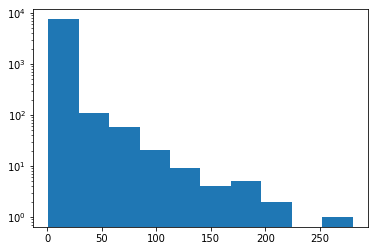

In [10]:
a=plt.hist(example_distribution,log=True)

In [11]:
# save file into desk
with open(AtLocation_sents_file,"w",encoding="utf-8") as f:
    for line in AtLocation_sents:
        f.write(line+"\n")

## More Sentences

In [12]:
# check the distribution of relation id
rel_dict=dict()
for line in cskg_dim_lines:
    rel_dict[line[2]]=rel_dict.get(line[2],0)+1
    
print("number of relation id:", len(rel_dict))

number of relation id: 47


In [13]:
rel_dict

{'/r/DefinedAs': 2173,
 '/r/HasContext': 238277,
 '/r/HasProperty': 9482,
 '/r/IsA': 316351,
 '/r/RelatedTo': 1703968,
 '/r/SimilarTo': 30635,
 '/r/Antonym': 401003,
 '/r/Synonym': 1245289,
 '/r/FormOf': 378859,
 '/r/AtLocation': 27797,
 '/r/DerivedFrom': 325914,
 '/r/EtymologicallyRelatedTo': 32075,
 '/r/CapableOf': 42375,
 '/r/InstanceOf': 1480,
 '/r/PartOf': 31964,
 '/r/MadeOf': 2757,
 '/r/ReceivesAction': 6037,
 '/r/HasA': 16973,
 '/r/UsedFor': 42580,
 '/r/NotHasProperty': 327,
 '/r/CausesDesire': 4688,
 '/r/HasSubevent': 25369,
 '/r/LocatedNear': 152274,
 '/r/DistinctFrom': 8249,
 '/r/MannerOf': 12618,
 '/r/Entails': 405,
 '/r/HasPrerequisite': 24977,
 '/r/NotCapableOf': 329,
 '/r/MotivatedByGoal': 9489,
 '/r/Desires': 3170,
 '/r/Causes': 17388,
 '/r/HasFirstSubevent': 3347,
 '/r/HasLastSubevent': 2874,
 '/r/NotDesires': 2886,
 '/r/CreatedBy': 450,
 '/r/EtymologicallyDerivedFrom': 71,
 '/r/SymbolOf': 4,
 'at:xAttr': 133281,
 'at:xEffect': 100307,
 'at:xIntent': 57685,
 'at:xReact'

In [14]:
#define the first word and second word used for build sentence:
# example:
# [I am going to], [and I am going to see]
relation_sentence={"/r/UsedFor":[['f"I want to {blank1} so I will need {blank2}"',"or",False],
                                 ['f"I want to have {blank1} so I will need {blank2}"',"or",False],
                                 ['f"I want to be {blank1} so I will need {blank2}"',"or",False]],
                   "/r/CreatedBy":[['f"I have {blank1} so I can create {blank2}"',"or", False]],
                   "/r/CapableOf":[['f"I have {blank1} so I am capable of {blank2}"',"or", True],
                                     ['f"I am {blank1} so I am capable of {blank2}"',"or", True]],
                   "/r/Causes":[['f"I have {blank1} so I will cause {blank2}"',"or", True],
                                  ['f"I am {blank1} so I will cause {blank2}"',"or", True]],
                   "/r/PartOf":[['f"I have {blank1} so I might also have {blank2}"',"or", False],
                                  ['f"I am {blank1} so I might also have {blank2}"',"or", False]],
                   "/r/MadeOf":[['f"I want to have {blank1} so I can make it from {blank2}"',"or", True]],
                   "/r/HasPrerequisite":[['f"If I want to {blank1} then I should {blank2}"',"or", True],
                                           ['f"If I want to be {blank1} then I should {blank2}"',"or", True],
                                           ['f"If I want to have {blank1} then I should {blank2}"',"or", True]],
                   "/r/CausesDesire":[['f"I want to {blank1} then I want to {blank2}"',"or", False],
                                        ['f"I want to {blank1} then I have {blank2}"',"or", False]],
                   "/r/NotDesires":[['f"I am {blank1} and I don\'t want to {blank2}"',"or", True]],
                   "/r/AtLocation":[['f"I need {blank1} so I will go to see {blank2}"',"or", True]],
                   '/r/LocatedNear':[['f"I am going to {blank1} and I am going to see {blank2} nearby"',"or", True]]}


# get the sentence that having the relation in relation_sentence
mul_filter_lines=list(data_filter(cskg_dim_head, cskg_dim_lines, filter_={"relation":relation_sentence.keys()}))

In [15]:
sents_example=[]
with open(gamesents_file,"w",encoding="utf-8") as f:
    for rel_id, lines in mul_filter_lines:
        temp= []
        for format_ in relation_sentence[rel_id]:
            sents,example_dict = build_sentence(lines,
                                 sent_format=format_[0],
                                 operation=format_[1],
                                 reverse_format=format_[2],)
            #print("relation id:",rel_id)
            #print("game sentences we can create:",len(sents))
            example_distribution=[len(example_dict[item]) for item in example_dict]
            avg_example= sum(example_distribution)/len(example_dict)
            #print("answers they have on average:", avg_example)
            #print("example of sentences:",sents[250])
            #print()
            if not temp:
                temp= [[sents[i]] for i in range(len(sents))]
            else:
                temp=[temp[i]+[sents[i]] for i in range(len(sents))]

        sents_example.append([rel_id,temp,example_dict])

        # save file into desk

        #f.write("**"+rel_id+"**\n")
        #for line in sents:
        #   f.write(line+"\n")

## Score sentence

In [16]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def score(tokens_tensor):
    loss=model(tokens_tensor, labels=tokens_tensor)[0]
    return np.exp(loss.cpu().detach().numpy())

def sents_pick(sents,scores,perplexity_threhold=100):
    i = min(len(sents), len(scores))
    sents_result=[]
    for idx in range(i):
        sent_collect=sents[idx]
        score_collect=scores[idx]
        
        temp=float("inf")
        result=""
        
        result_idx=0
        temp_idx=0
        for sent, score in zip(sent_collect,score_collect):
            if temp>score:
                temp=score
                result=sent
                result_idx=temp_idx
            temp_idx+=1
        if temp < perplexity_threhold:
            sents_result.append([result_idx,result])
        
    return sents_result

In [17]:
relation_scores=[]
for relation_collection in sents_example:
    rel_id=relation_collection[0]
    scores=[]
    print("process relation id:", rel_id)
    for sents in tqdm(relation_collection[1]):
        temp=[]
        for sent in sents:
            # too long sentence might out of index
            if len(sent)>2000:
                temp.append(float("inf"))
                continue
            tokens_tensor = tokenizer.encode(sent, add_special_tokens=False, return_tensors="pt")           
            temp.append(score(tokens_tensor))
        scores.append(temp)
    relation_scores.append([rel_id,scores])

  0%|          | 1/30174 [00:00<1:28:51,  5.66it/s]

process relation id: /r/UsedFor


  1%|          | 4/388 [00:00<00:11, 34.17it/s]

process relation id: /r/CreatedBy


  0%|          | 2/11488 [00:00<12:05, 15.84it/s]

process relation id: /r/CapableOf


  0%|          | 0/1980 [00:00<?, ?it/s]

process relation id: /r/Causes


  0%|          | 0/14005 [00:00<?, ?it/s]

process relation id: /r/PartOf


  0%|          | 3/2239 [00:00<01:35, 23.44it/s]

process relation id: /r/MadeOf


  0%|          | 2/3942 [00:00<06:14, 10.51it/s]

process relation id: /r/HasPrerequisite


  0%|          | 2/598 [00:00<00:58, 10.12it/s]

process relation id: /r/CausesDesire


  1%|          | 3/255 [00:00<00:09, 26.92it/s]

process relation id: /r/NotDesires


  0%|          | 4/9894 [00:00<05:03, 32.63it/s]

process relation id: /r/AtLocation


  0%|          | 3/16154 [00:00<09:19, 28.86it/s]

process relation id: /r/LocatedNear


100%|██████████| 16154/16154 [11:23<00:00, 23.62it/s]


In [18]:
# find the sentence with highest score/lowest perplexity and satisfy threshold
filtered_sents_example=[]

for idx_1 in range(len(sents_example)):
    rel_id=sents_example[idx_1][0]
    example_dict=sents_example[idx_1][2]
    sents=sents_example[idx_1][1]
    scores=relation_scores[idx_1][1]
    
    filtered_sent=sents_pick(sents,scores)
    filtered_sents_example.append([rel_id,filtered_sent,example_dict])

In [19]:
# based on the string pattern build edges
edges=[]
for relation_sents in filtered_sents_example:
    rel_id=relation_sents[0]
    ids_sents=relation_sents[1]
    patterns_=relation_sentence[rel_id]
    for id_, sent in tqdm(ids_sents):
        pattern_undefine=patterns_[id_][0]
        reverse=patterns_[id_][2]
        connection=patterns_[id_][1]
        pattern=pattern_undefine.replace("{blank1}","(.*)").replace("{blank2}","(.*)").replace('f"',"").replace('"',"")
        
        blank1,blank2s=re.findall(pattern, sent)[0]
        blank2s_list=blank2s.split(" "+connection+" ")
        
        for blank2 in blank2s_list:
            if reverse:
                subject_=blank1
                object_=blank2
                edges.append([subject_,rel_id,object_])
            else:
                subject_=blank2
                object_=blank1
                edges.append([subject_,rel_id,object_])

100%|██████████| 1633/1633 [00:00<00:00, 38720.67it/s]


3.6594694632942626
1.375
14.898009950248756
29.209183673469386
5.151807228915662
1.24
12.447835344215756
8.895348837209303
1.2828282828282829
13.139393939393939
38.519902020820574


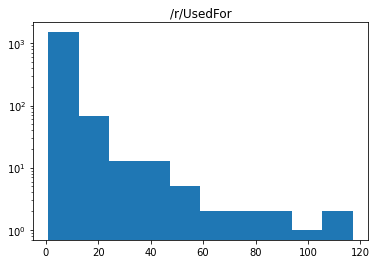

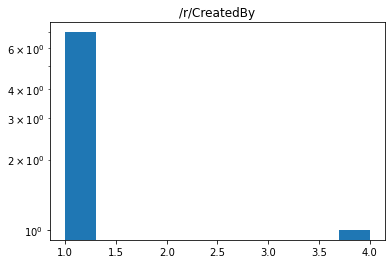

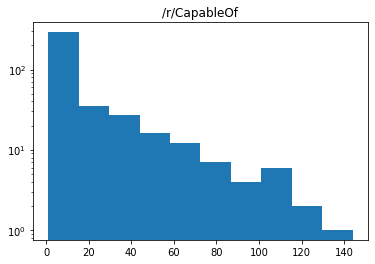

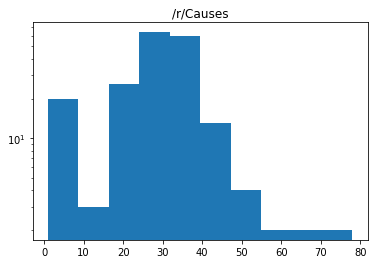

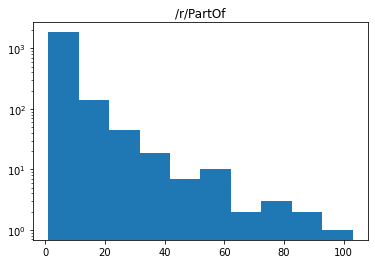

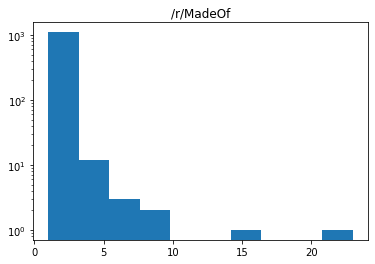

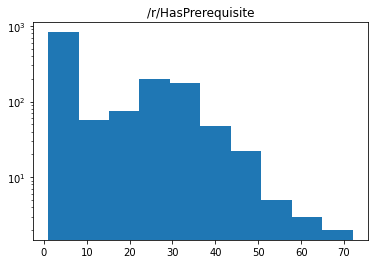

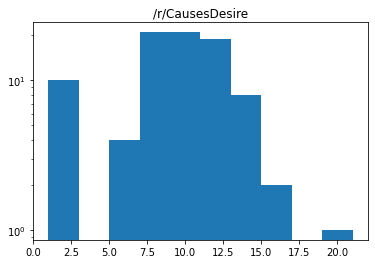

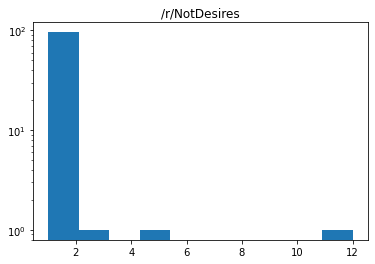

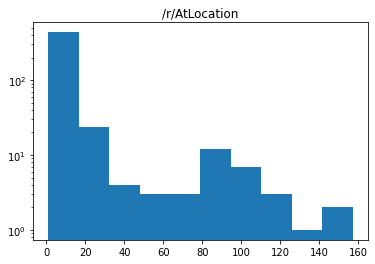

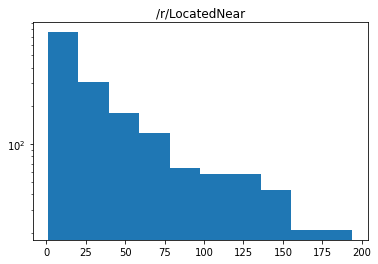

In [20]:
# calculate the number of answer for different relation id

for relation_sents in filtered_sents_example:
    fig = plt.figure()
    # count the number of " or " n1 in the sentence
    # the answer of one sentence is n1+1
    rel_id=relation_sents[0]
    id_sents=relation_sents[1]
    distribution=[]
    for id_, sent in id_sents:
        num_or = sent.count(" or ")
        distribution.append(num_or+1)    
    a=plt.hist(distribution,log=True)
    plt.title(rel_id)
    print(sum(distribution)/len(distribution))

# Build Graph

In [21]:
def add2graph(graph, rel_id, subject_, object_,rel_set=relation_sentence):
    temp = graph_tool.util.find_vertex(g, g.vp["position"], subject_)
    if not temp:
        a = graph.add_vertex()
        g.vp["position"][a]=subject_
    else:
        a=temp[0]
        
    temp = graph_tool.util.find_vertex(g, g.vp["position"], object_)
    if not temp:
        b = graph.add_vertex()
        g.vp["position"][b]=object_
    else:
        b=temp[0]
        
    edge_loc=graph_tool.util.find_edge(g, g.ep["position"], rel_id)
    if not edge_loc:
        reverse=relation_sentence[rel_id][2]
        
        if reverse==True:
            c = graph.add_edge(a, b)
            g.ep["position"][c]=rel_id.split("/")[-1].split(":")[-1]
        else:
            c = graph.add_edge(b, a)
            g.ep["position"][c]=rel_id.split("/")[-1].split(":")[-1]
    else:
        c = edge_loc[0]
        
    return

def random_walk(num=2):
    step=0
    process=[]
    root=None
    
    while step<num:
        # random select root
        if root == None:
            root_name = random.sample(label_limit, 1)[0]
            if root_name in G:
                root=G[root_name]
            else:
                continue
            
        else:
            #print(list(root.out_neighbors()))
            root_name= random.sample(root.keys(), 1)[0]
            if root_name in G:
                root=G[root_name]
            else:
                step=0
                process=[]
                root=None
                continue
            #print("second root", root)
        
        if G.out_degree[root_name]==0:
            step=0
            process=[]
            root=None
            continue
        
        #print(root,root.out_degree())
        if root_name in process:
            step=0
            process=[]
            root=None
            continue
        process.append(root_name)
        step+=1
    process.append(random.sample(root.keys(), 1)[0]) 
    return process

def all_relation_walk(threshold=100,relation_list=["/r/UsedFor"]):
    # generate a sentence with all relation labels
    relation_set=set(relation_list)
    process=[]
    root_name=""
    step=0
    
    while step<threshold:
        #print(process, step,relation_set,threshold,root_name)
        step+=1
        if root_name == "":
            root_name = random.sample(label_limit, 1)[0].replace(" ","_")
            if root_name in G:
                pass
            else:
                root_name = ""
                continue
                
        else:
            #print(list(root.out_neighbors()))
            all_edges=list(G.out_edges(root_name, data=True))
            random.shuffle(all_edges)
            status = False
            for sub, obj, rel in all_edges:
                rel_label=rel["label"]
                if rel_label in relation_set:
                    status=True
                    break
            
            if status:
                root_name=obj
                relation_set.remove(rel_label)
                if relation_set==set():
                    process.append(root_name)
                    break
            else:
                process=[]
                root_name=""
                relation_set=set(relation_list)
                continue
            #print("second root", root)
        
        if G.out_degree[root_name]==0:
            process=[]
            root_name=""
            relation_set=set(relation_list)
            continue
        
        #print(root,root.out_degree())
        # remove duplicate
        if root_name in process:
            process=[]
            root_name=""
            continue

        process.append(root_name)
    return process

def walk_sent(process):
    sent=""
    for p2 in range(1, len(process)):
        p1=p2-1
        sub=process[p1].replace(" ","_")
        obj=process[p2].replace(" ","_")
        
        relation_=G[sub][obj]["label"]
        
        if sent:
            sent+="-"+relation_+"-"+obj
        else:
            sent=sub+"-"+relation_+"-"+obj
            
    return sent

def walk2gamesents(sent, relation2label, relation_swap={"/r/LocatedNear"}):
    sent_token=sent.split("-")
    gamesent=""
    i=0
    while i < len(sent_token):
        if i==0:
            gamesent+=sent_token[i].replace("_"," ")
        
        elif i==1:
            rel_id=sent_token[i]
            if rel_id in relation_swap:
                rel_label=G_total[sent_token[i-1]][sent_token[i+1]]["label"]
            else:
                rel_label=relation2label[sent_token[i]]
            
            gamesent+=" "+rel_label
            
        elif (i+1)%2==0:
            gamesent+=" "+ "that"+" "+relation2label[sent_token[i]]
        
        else:
            gamesent+= " "+sent_token[i].replace("_"," ")
        i+=1
    return gamesent

In [22]:
relation2label={"/r/UsedFor":"is used for","/r/CreatedBy":"is created by","/r/CapableOf":"is capable of",
                "/r/Causes":"casuses","/r/PartOf":"is part of","/r/HasContext":'has context,',"/r/MadeOf":"is made of",
                "/r/HasPrerequisite":"has prerequisite,","/r/CausesDesire": "causes desire,","/r/NotDesires":"does not desire",
                "/r/AtLocation":"is located in","/r/LocatedNear":"is located near in"}

In [23]:
label_limit = set(["rug","piano","dryer","computer","fireplace","whiteboard","bookshelf","wardrobe cabinet",
                  "pan","toilet","plates","ottoman","fish tank","dishwasher","microwave","water dispenser",
                  "bed","table","mirror","tv stand","stereo set","chessboard","playstation","vacuum cleaner",
                  "cup","xbox","heater","bathtub","shoe rack","range oven","refrigerator","coffee machine",
                  "sink","sofa","kettle","dresser","knife rack","towel rack","loudspeaker","utensil holder",
                  "desk","vase","shower","washer","fruit bowl","television","dressing table","cutting board",
                  "ironing board","food processor"])

In [24]:
G = nx.DiGraph()
for edge in edges:
    sub,rel,obj=edge
    sub=sub.replace(" ","_")
    obj=obj.replace(" ","_")
    G.add_edge(sub,obj,label=rel)

In [80]:
# build the graph for the whole dataset.
G_total= nx.DiGraph()
for line in cskg_dim_lines:
    G_total.add_edge(line[4].replace(" ","_"),line[5].replace(" ","_"),label=line[6], head_tail=[line[1],line[3]])

In [26]:
#show 10 example
for i in range(10):
    temp=random_walk(num=3)
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
    value=score(tokens_tensor)
    print("random walk: ", sent)
    print("gamesentence is: ", gamesent)
    print(value)
    print()

random walk:  dresser-/r/LocatedNear-knob-/r/LocatedNear-meter-/r/LocatedNear-pay_by_cell_phone
gamesentence is:  dresser has a knob that is located near in meter that is located near in pay by cell phone
230.62224

random walk:  toilet-/r/LocatedNear-shed-/r/LocatedNear-wall-/r/PartOf-house
gamesentence is:  toilet in shed that is located near in wall that is part of house
172.06158

random walk:  dresser-/r/LocatedNear-kitchen-/r/LocatedNear-tools-/r/AtLocation-neighbor's_house
gamesentence is:  dresser related to kitchen that is located near in tools that is located in neighbor's house
219.56825

random walk:  sofa-/r/UsedFor-watching_television-/r/UsedFor-education-/r/UsedFor-learning
gamesentence is:  sofa is used for watching television that is used for education that is used for learning
72.216415

random walk:  piano-/r/LocatedNear-wall-/r/PartOf-building-/r/UsedFor-live_in
gamesentence is:  piano against wall that is part of building that is used for live in
350.78207

random 

In [27]:
#show 10 example
for i in range(10):
    temp=random_walk(num=2)
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    print("random walk: ", sent)
    print("gamesentence is: ", gamesent)
    print()

random walk:  fireplace-/r/LocatedNear-arch-/r/LocatedNear-trolley
gamesentence is:  fireplace has arch that is located near in trolley

random walk:  computer-/r/LocatedNear-coffee-/r/LocatedNear-spoon_handle
gamesentence is:  computer next to coffee that is located near in spoon handle

random walk:  sofa-/r/AtLocation-house-/r/LocatedNear-roof
gamesentence is:  sofa is located in house that is located near in roof

random walk:  bed-/r/UsedFor-resting-/r/Causes-being_late_to_work
gamesentence is:  bed is used for resting that casuses being late to work

random walk:  heater-/r/LocatedNear-loop-/r/LocatedNear-dock
gamesentence is:  heater has loop that is located near in dock

random walk:  kettle-/r/LocatedNear-kitchen-/r/LocatedNear-fridge
gamesentence is:  kettle in kitchen that is located near in fridge

random walk:  vase-/r/LocatedNear-junkyard-/r/LocatedNear-fence
gamesentence is:  vase in junkyard that is located near in fence

random walk:  television-/r/LocatedNear-window-/

In [28]:
temp=all_relation_walk(threshold=100000,relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"])
temp

['piano', 'drawing_room', 'sitting', 'wall', 'house', 'rooms']

In [29]:
sent=walk_sent(temp)
gamesent=walk2gamesents(sent, relation2label)
tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
score(tokens_tensor)

79.48515

In [58]:
# load cskg embedding file
with open(cskg_embeddings_file,"r") as f:
    head= f.readline().strip().split("\t")
    
    # obtain embedding_sentence in file
    cskg_word_embeddings=dict()
    
    for item in tqdm(f):
        # obtain list of line
        line=item.strip().split("\t")
        
        # only property is text embedding can obtain embeddings
        word=line[0]
        prop=line[1]
        embedding=line[2]
        
        if prop=="text_embedding":
            cskg_word_embeddings[word]=embedding

4322096it [00:50, 85252.24it/s]


In [99]:
example_sents_set=set()
sent_score_list=[]
relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"]
for i in tqdm(range(100)):
    temp=all_relation_walk(threshold=100000,relation_list=relation_list)
    if len(temp)<=len(relation_list):
        continue
        
    node_ids=[0]*len(temp)
    for i in range(1,len(temp)):
        p1=i-1
        p2=i
        
        head=temp[p1]
        tail= temp[p2]
        
        head_tail=G_total[head][tail]["head_tail"]
        head_id= head_tail[0]
        tail_id=head_tail[1]
        
        node_ids[p1]=head_id
        node_ids[p2]=tail_id
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    
    head_id=node_ids[0]
    tail_id=node_ids[-1]
    
    head_embed=np.array(eval("["+cskg_word_embeddings[head_id]+"]"))
    tail_embed=np.array(eval("["+cskg_word_embeddings[tail_id]+"]"))
    similar=dot(head_embed, tail_embed)/(norm(head_embed)*norm(tail_embed))
    
    if gamesent in example_sents_set:
        continue
    else:
        example_sents_set.add(gamesent)
    tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
    sent_score_list.append([gamesent,score(tokens_tensor),similar])

100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


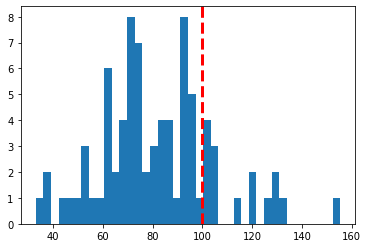

In [100]:
a=plt.hist([item[1] for item in sent_score_list],bins=40)
plt.axvline(100, color='r', linestyle='dashed', linewidth=3)

In [101]:
# sort sentence by similarity
sent_score_list.sort(key=lambda k:k[-1], reverse=True)

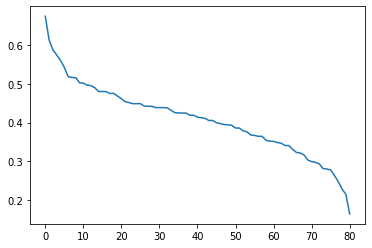

In [102]:
y1= [_[-1] for _ in sent_score_list]
y2 = [_[1] for _ in sent_score_list]
x= range(len(sent_score_list))


plt.plot(x,y1)

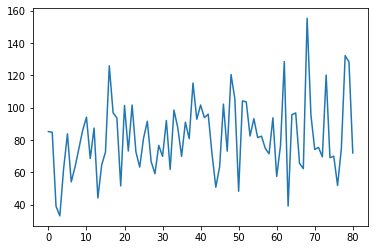

In [103]:
plt.plot(x,y2)

# New Task
The edges can have the thing as a subject or object
This requires double templates
X is used for Y
Y uses X

In [35]:
relation2label={"/r/UsedFor":"is used for","/r/CreatedBy":"is created by","/r/CapableOf":"is capable of",
                "/r/Causes":"casuses","/r/PartOf":"is part of","/r/HasContext":'has context,',"/r/MadeOf":"is made of",
                "/r/HasPrerequisite":"has prerequisite,","/r/CausesDesire": "causes desire,","/r/NotDesires":"does not desire",
                "/r/AtLocation":"is located in","/r/LocatedNear":"is located near",
                "/r/AtLocation/r":"has","/r/UsedFor/r":"uses","/r/PartOf/r": "has a part,","/r/MadeOf/r":"is used to make","/r/LocatedNear/r":"is located near",}
relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"]

In [36]:
G = nx.DiGraph()
for edge in edges:
    sub,rel,obj=edge
    sub=sub.replace(" ","_")
    obj=obj.replace(" ","_")
    if rel in relation_list:
        G.add_edge(sub,obj,label=rel)

In [37]:
def star_walk(threshold=100):
    nodes=["",[],[]]
    relation_limit_set=set(relation_list)
    
    for i in range(threshold):
        # pick one word from eqa
        root_name = random.sample(label_limit, 1)[0]
        
        # check whether it has 5 different relation
        if not G.has_node(root_name):
            continue
            
        out_edges=G.out_edges(root_name)
        in_edges=G.in_edges(root_name)
        relation_set=set()
        
        for u,v in out_edges:
            rel_name=G[u][v]["label"]
            relation_set.add(rel_name)
            
        for u,v in in_edges:
            rel_name=G[u][v]["label"]
            relation_set.add(rel_name)
            
        if not len(relation_set)>=len(relation_list)-2:
            #print(relation_set,root_name)
            continue
            
        #print(relation_set,root_name)
        nodes[0]=root_name
        
        shuffle_out_edges=list(out_edges)
        shuffle_in_edges=list(in_edges)
        random.shuffle(shuffle_out_edges)
        random.shuffle(shuffle_in_edges)
        #print(shuffle_out_edges,shuffle_in_edges)
        for u,v in shuffle_out_edges:
            rel_name=G[u][v]["label"]
                
            if rel_name in relation_limit_set:
                relation_limit_set.remove(rel_name)
            else:
                continue
                
            nodes[1].append(v)
            nodes[2].append(rel_name)
            
            if not relation_limit_set:
                break
                
        for u,v in shuffle_in_edges:
            rel_name=G[u][v]["label"]
            
            if not relation_limit_set:
                break
                
            if rel_name in relation_limit_set:
                relation_limit_set.remove(rel_name)
            else:
                continue
                
            nodes[1].append(u)
            nodes[2].append(rel_name+"/r") 
        
        if nodes[0]:
            break
            
    return nodes

def build_sentences(nodes):
    root_=nodes[0]
    sent1_list=[]
    sent2_list=[]
    for node, rel_ in zip(nodes[1],nodes[2]):
        sub_sent1=f"{root_} {relation2label[rel_]} {node}"
        sub_sent2=f"{relation2label[rel_]} {node}"
        sent1_list.append(sub_sent1)
        sent2_list.append(sub_sent2)
        
    sent1=" and ".join(sent1_list)+"."
    sent2=root_+" "+" and ".join(sent2_list)+"."
    sent1=sent1.replace("_"," ")
    sent2=sent2.replace("_"," ")
    
    return sent1,sent2

In [38]:
nodes_combine=star_walk()
build_sentences(nodes_combine)

('bathtub is located near tiled frame and bathtub is used for take bath and bathtub has water.',
 'bathtub is located near tiled frame and is used for take bath and has water.')

In [39]:
example_sents_set=set()
sent_score_list1=[]
sent_score_list2=[]
for i in tqdm(range(100)):
    nodes_combine=star_walk()
    if not nodes_combine[0]:
        continue
    sent1,sent2=build_sentences(nodes_combine)
    if sent1 in example_sents_set:
        continue
    else:
        example_sents_set.add(sent1)
    tokens_tensor = tokenizer.encode(sent1, add_special_tokens=False, return_tensors="pt")           
    sent_score_list1.append([sent1,score(tokens_tensor)])
    
    tokens_tensor = tokenizer.encode(sent2, add_special_tokens=False, return_tensors="pt")           
    sent_score_list2.append([sent2,score(tokens_tensor)])

100%|██████████| 100/100 [00:08<00:00, 12.37it/s]


In [40]:
score_list1=[]
score_list2=[]
for item1,item2 in zip(sent_score_list1,sent_score_list2):
    sent1,res1=item1
    sent2,res2=item2
    score_list1.append(res1)
    score_list2.append(res2)

In [41]:
sum(score_list1)/len(score_list1)

146.73291304617217

In [42]:
sum(score_list2)/len(score_list2)

170.31979061858823

In [43]:
filter_sents=[]

for sent, val in sent_score_list1:
    if val <=100:
        filter_sents.append([sent,val])

In [44]:
filter_sents[:20]

[['toilet is located near cord and toilet is located in apartment and toilet is made of porcelain.',
  72.901566],
 ['sink is located in house and sink is located near drain and sink is used for wash hands.',
  94.724976],
 ['computer is located near grass and computer is located in building and computer is used for create artificial intelligence and computer is made of microchips and computer has a part, cpu.',
  78.60975],
 ['computer is made of hardware and computer is located near knees and computer is used for entertainment and computer is located in school and computer has a part, CRT.',
  84.900154],
 ['computer is located near label and computer is located in table and computer is used for work and computer is made of microchips and computer has a part, computer accessory.',
  70.66183],
 ['shower is located near bed and shower is used for washing and shower is part of house and shower has hot faucet.',
  66.30867],
 ['piano is located in drawing room and piano is located near 

In [45]:
G.in_edges("shower")

InEdgeDataView([('hair_conditioner', 'shower'), ('hot_faucet', 'shower'), ('snake', 'shower'), ('water', 'shower'), ('counter', 'shower'), ('pipe', 'shower'), ('seal', 'shower'), ('bar', 'shower'), ('room', 'shower'), ('barrier', 'shower'), ('enclosure', 'shower'), ('bucket', 'shower'), ('lighting', 'shower'), ('fixture', 'shower'), ('beam', 'shower'), ('bidet', 'shower'), ('vent', 'shower'), ('bottom', 'shower'), ('faucet', 'shower'), ('ceiling', 'shower'), ('items', 'shower'), ('dish', 'shower'), ('corner', 'shower'), ('mat', 'shower'), ('hook', 'shower'), ('ledge', 'shower'), ('faucet_for_shower', 'shower'), ('pan', 'shower'), ('hose', 'shower'), ('soap', 'shower'), ('step', 'shower'), ('seat', 'shower'), ('opening', 'shower'), ('panel', 'shower'), ('planter', 'shower'), ('plumbing', 'shower'), ('rings', 'shower'), ('rod', 'shower'), ('soap_dish', 'shower'), ('sponge', 'shower'), ('toilet', 'shower'), ('toilet_bowl', 'shower'), ('towel_rack', 'shower'), ('towel_bar', 'shower'), ('tr

In [46]:
test=set()
for u,v in G.out_edges("refrigerator"):
    rel_label=G[u][v]["label"]
    test.add(rel_label)

In [47]:
test

{'/r/UsedFor'}